In [1]:
from fetch_it import mnist
x_train, y_train, x_test, y_test = mnist()

In [2]:
import numpy as np
from frame import layer_init

In [3]:
"""add batch"""
"""this works but difficult to add batch"""
def forward_backward(x,y,Dense1,Dense2):
    x = x.reshape((784,1)) # (784,1)
    l1 = Dense1.T.dot(x) # (128,1)
    l2 = l1.T.dot(Dense2) # (1,10)
    pred = l2.T # (10,1)
    # backward
    # encoding label
    label = np.zeros(pred.shape) # (10,1)
    label[:][y] = 1
    assert label.shape[0] == 10
    # loss: cross entropy
    assert pred.shape == label.shape
    los = pred - np.log(np.exp(pred).sum(axis=0))# softmax + CCE
    loss = -(np.multiply(label,los.mean())).mean() # scalar
    #return loss
    #Something crappy occurred suddenly
    #overflow encountered if 'len(label)' is removed
    d_loss = -np.multiply(label/len(label), 1 - np.log(np.exp(label/len(label)).sum())) # (10,1)
    d_l2 = l1.dot(d_loss.T) # (128,10)
    d_l1 = x*(d_l2.mean(axis=1)) # (784, 128)
    
    assert d_l2.shape == Dense2.shape
    assert d_l1.shape == Dense1.shape
    return pred, loss, d_l1, d_l2
    

In [36]:
def f_b_batch(x,y,Dense1,Dense2):
    # forward pass
    x = x.reshape((y.shape[0],784)) # (32,784)
    l1 = x.dot(Dense1) # (32,128)
    l2 = l1.dot(Dense2) # (32,10)
    pred = l2 # (32,10): col vector
    # encode label
    label = np.zeros((len(y),10),np.float32) # (32,10)
    label[range(label.shape[0]),y] = 1
    assert label.shape == pred.shape
    # loss cal
    """overflow encountered"""
    los = pred - np.log(np.exp(pred-pred.max()).sum(axis=0))*pred.max() # softmax + CCE
    loss = -(np.multiply(label,los)).mean(axis=1) # size = batchsize
    # backward
    d_out = label/len(label[0])
    grads = -np.multiply(d_out,1 - np.exp(d_out)/(np.exp(d_out).sum(axis=0)))
    #grads = d_out - np.exp(-loss)*d_out.sum(axis=1).reshape((-1,1))
    d_l2 = l1.T.dot(grads)
    assert d_l2.shape == Dense2.shape
    d_l1 = x.T.dot((l1.T.dot(grads.dot(l2.T))).T)
    assert d_l1.shape == Dense1.shape
    return pred, loss, d_l1, d_l2

In [37]:
from tqdm import tqdm
# training loop
def training(x,y,lr=1e-3,epoch=1000,batch_size=32):
    Dense1 = layer_init(784,128)
    Dense2 = layer_init(128,10)
    losses = []
    for i in tqdm(range(epoch)):
        samp = np.random.randint(0,x.shape[0])
        # X = x[samp]
        # Y = y[samp]
        # pred, loss, d_l1, d_l2 = forward_backward(X,Y,Dense1,Dense2)

        X = x[samp:samp+batch_size]
        Y = y[samp:samp+batch_size]
        pred, loss, d_l1, d_l2 = f_b_batch(X,Y,Dense1,Dense2)

        assert d_l1.shape == Dense1.shape
        assert d_l2.shape == Dense2.shape

        # SGD
        Dense2 -= lr*d_l2
        Dense1 -= lr*d_l1

        losses.append(loss.mean())
    
    return losses, Dense1, Dense2

100%|██████████| 500/500 [00:00<00:00, 3969.40it/s]


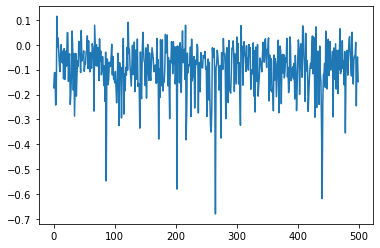

In [38]:
import matplotlib.pyplot as plt
losses, Dense1, Dense2 = training(x_train,y_train,lr=1e-5,epoch=500,batch_size=1)
plt.plot(losses)

In [39]:
def evaluate(x,y,d1,d2):
    """Simply forward pass"""
    x = x.reshape((-1,1)) # (784,1)
    l1 = d1.T.dot(x) # (128,1)
    l2 = l1.T.dot(d2) # (1,10)
    pred = l2.T # (10,1)
    return (pred.argmax() == y).astype(np.float32)

accu = []
for i in range(1000):
    accu.append(evaluate(x_test[i],y_test[i],Dense1,Dense2))

print(sum(accu)/len(accu))

0.075
